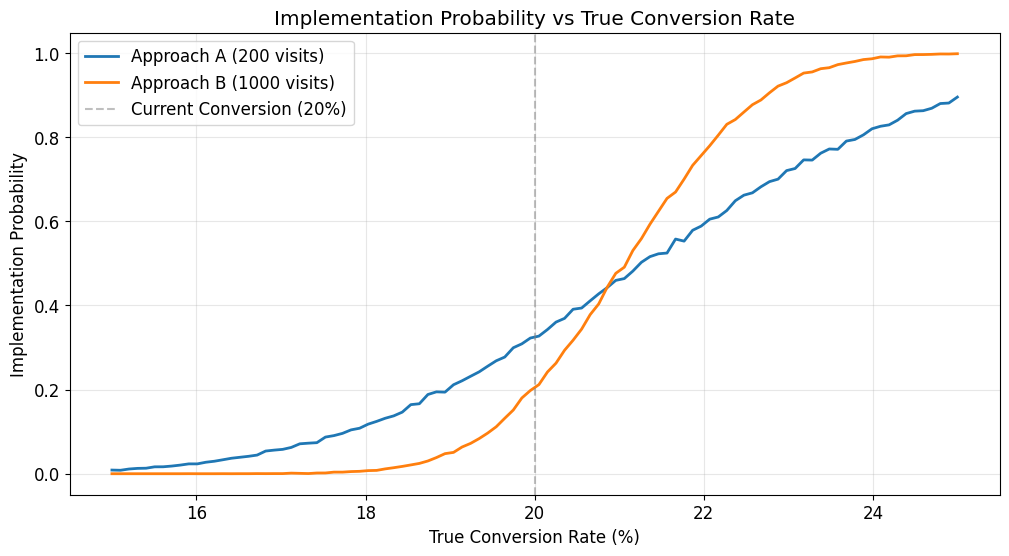

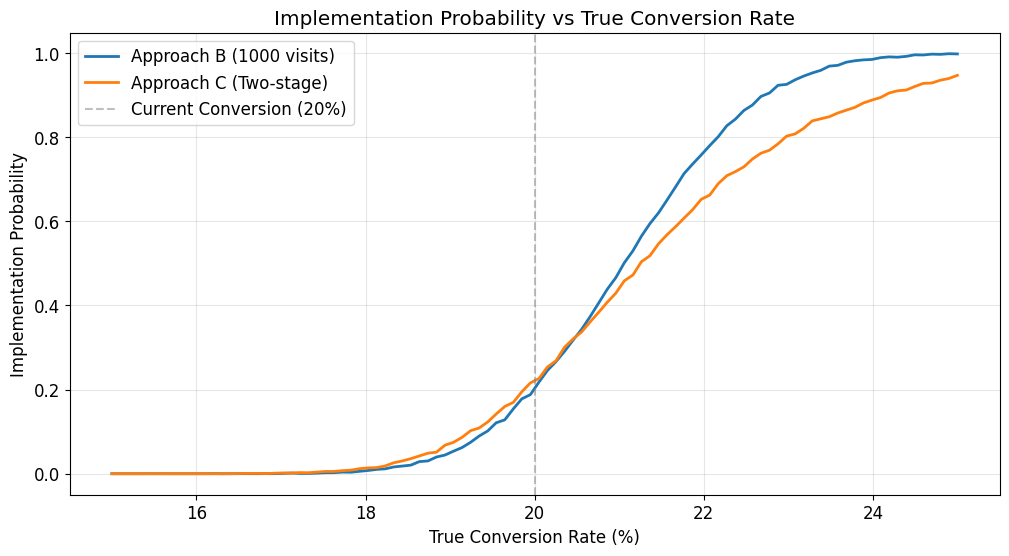

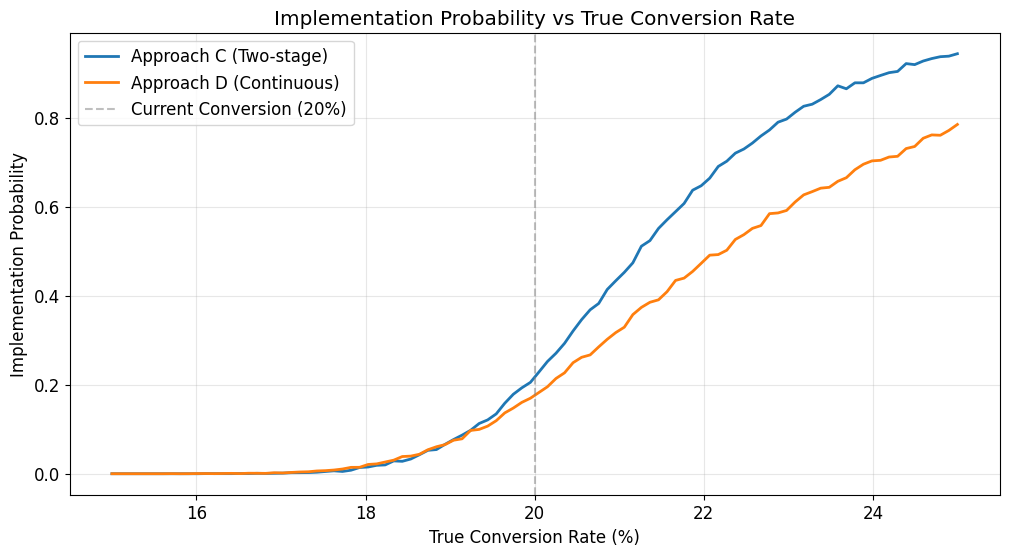

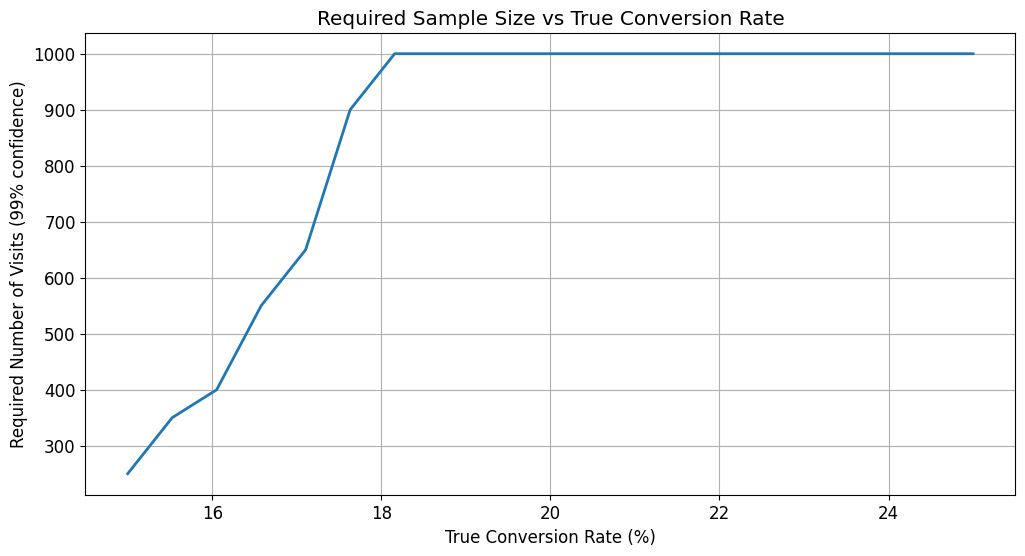

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import List, Tuple, Callable
import pandas as pd

class ConversionAnalysis:
    def __init__(self, seed: int = 42):
        np.random.seed(seed)
        self.setup_plot_style()
        
    def setup_plot_style(self):
        plt.rcParams['figure.figsize'] = (12, 6)
        plt.rcParams['font.size'] = 12
        
    def simulate_conversions(self, true_rate: float, n_visits: int, 
                           n_simulations: int = 10000) -> np.ndarray:
        return np.random.binomial(n=n_visits, p=true_rate, size=n_simulations)
    
    def calculate_implementation_probability(self, true_rate: float, n_visits: int, 
                                          threshold: float, n_simulations: int = 10000) -> float:
        conversions = self.simulate_conversions(true_rate, n_visits, n_simulations)
        observed_rates = conversions / n_visits
        return np.mean(observed_rates > threshold)

class BlueLevelAnalysis:
    def __init__(self):
        self.analysis = ConversionAnalysis()
    
    def task_1_approach_a(self, true_rate: float) -> float:
        return self.analysis.calculate_implementation_probability(
            true_rate=true_rate,
            n_visits=200,
            threshold=0.21
        )
    
    def task_2_approach_b(self, true_rate: float) -> float:
        return self.analysis.calculate_implementation_probability(
            true_rate=true_rate,
            n_visits=1000,
            threshold=0.21
        )
    
    def task_3_comparison_plot(self):
        true_rates = np.linspace(0.15, 0.25, 100)
        
        plt.figure(figsize=(12, 6))
        probs_a = [self.task_1_approach_a(rate) for rate in true_rates]
        plt.plot(true_rates * 100, probs_a, label='Approach A (200 visits)', linewidth=2)
        probs_b = [self.task_2_approach_b(rate) for rate in true_rates]
        plt.plot(true_rates * 100, probs_b, label='Approach B (1000 visits)', linewidth=2)
        
        self._add_plot_decorations()
        return plt.gcf()
    
    def _add_plot_decorations(self):
        plt.axvline(x=20, color='gray', linestyle='--', alpha=0.5, label='Current Conversion (20%)')
        plt.grid(True, alpha=0.3)
        plt.xlabel('True Conversion Rate (%)')
        plt.ylabel('Implementation Probability')
        plt.legend()
        plt.title('Implementation Probability vs True Conversion Rate')
        
class RedLevelAnalysis:
    def __init__(self):
        self.analysis = ConversionAnalysis()
        self.blue_level = BlueLevelAnalysis()
    
    def two_stage_probability(self, true_rate: float, n_visits1: int = 200, 
                            n_visits2: int = 800, threshold: float = 0.20) -> float:
        stage1_conversions = self.analysis.simulate_conversions(true_rate, n_visits1)
        stage1_rates = stage1_conversions / n_visits1
        passed_stage1 = stage1_rates > threshold
        
        stage2_conversions = self.analysis.simulate_conversions(true_rate, n_visits2)
        stage2_rates = stage2_conversions / n_visits2
        passed_stage2 = stage2_rates > threshold
        
        return np.mean(passed_stage1 & passed_stage2)
    
    def task_1_approach_c(self, true_rate: float) -> float:
        return self.two_stage_probability(true_rate)
    
    def task_2_comparison_plot(self):
        true_rates = np.linspace(0.15, 0.25, 100)
        
        plt.figure(figsize=(12, 6))
        probs_b = [self.blue_level.task_2_approach_b(rate) for rate in true_rates]
        plt.plot(true_rates * 100, probs_b, label='Approach B (1000 visits)', linewidth=2)
        probs_c = [self.task_1_approach_c(rate) for rate in true_rates]
        plt.plot(true_rates * 100, probs_c, label='Approach C (Two-stage)', linewidth=2)
        
        self.blue_level._add_plot_decorations()
        return plt.gcf()

class BlackLevelAnalysis:
    def __init__(self):
        self.analysis = ConversionAnalysis()
        self.red_level = RedLevelAnalysis()
    
    def continuous_implementation_probability(self, true_rate: float, initial_visits: int = 200,
                                           max_visits: int = 1000, threshold: float = 0.196, 
                                           step_size: int = 50) -> float:
        results = np.zeros(10000, dtype=bool)
        
        for sim in range(10000):
            total_conversions = 0
            current_visits = 0
            continue_testing = True
            
            while continue_testing and current_visits < max_visits:
                new_visits = min(step_size, max_visits - current_visits)
                new_conversions = np.random.binomial(n=new_visits, p=true_rate)
                
                total_conversions += new_conversions
                current_visits += new_visits
                
                current_rate = total_conversions / current_visits
                
                if current_rate < threshold:
                    continue_testing = False  
                elif current_visits >= max_visits:
                    results[sim] = True
                    
        return np.mean(results)
    
    def task_1_approach_d(self, true_rate: float) -> float:
        return self.continuous_implementation_probability(true_rate)
    
    def task_2_comparison_plot(self):
        true_rates = np.linspace(0.15, 0.25, 100)
        
        plt.figure(figsize=(12, 6))
        probs_c = [self.red_level.task_1_approach_c(rate) for rate in true_rates]
        plt.plot(true_rates * 100, probs_c, label='Approach C (Two-stage)', linewidth=2)
        probs_d = [self.task_1_approach_d(rate) for rate in true_rates]
        plt.plot(true_rates * 100, probs_d, label='Approach D (Continuous)', linewidth=2)
        
        self.red_level.blue_level._add_plot_decorations()
        return plt.gcf()
    
    def task_3_threshold_analysis(self):
        true_rates = np.linspace(0.15, 0.25, 20)
        thresholds = []
        
        for rate in true_rates:
            visits = []
            for n in range(200, 1001, 50):
                prob = self.continuous_implementation_probability(rate, max_visits=n)
                if prob < 0.01:
                    visits.append(n)
                    break
            if visits:
                thresholds.append(min(visits))
            else:
                thresholds.append(1000)
        
        plt.figure(figsize=(12, 6))
        plt.plot(true_rates * 100, thresholds, linewidth=2)
        plt.xlabel('True Conversion Rate (%)')
        plt.ylabel('Required Number of Visits (99% confidence)')
        plt.title('Required Sample Size vs True Conversion Rate')
        plt.grid(True)
        return plt.gcf()

def main():
    blue = BlueLevelAnalysis()
    red = RedLevelAnalysis()
    black = BlackLevelAnalysis()
    
    test_rates = [0.18, 0.20, 0.22]
    
    for rate in test_rates:
        blue.task_1_approach_a(rate)
        blue.task_2_approach_b(rate)
    blue.task_3_comparison_plot()
    plt.show()
    
    for rate in test_rates:
        red.task_1_approach_c(rate)  
    red.task_2_comparison_plot()
    plt.show()
    
    for rate in test_rates:
        black.task_1_approach_d(rate)
    black.task_2_comparison_plot()
    plt.show()
    black.task_3_threshold_analysis()
    plt.show()

if __name__ == "__main__":
    main()

# PRESENTATION
https://docs.google.com/presentation/d/157xMr9cBzrWR2bD5eT9KGAw1CdRv6r-leh4Q6mhb60U/edit?usp=sharing